In [1]:
###
# The goal of this notebook is to:
# - Take two neural populations
# - Compute the JS divergence between stimuli pairs for each population (the same stimuli pairs)
# - Compute the mutual information between the distributions of JS divergences

import glob
import os
from importlib import reload
import pickle
import datetime

import numpy as np
import scipy as sp
import pandas as pd
import h5py as h5
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import neuraltda.topology2 as tp2
import neuraltda.spectralAnalysis as sa
import neuraltda.simpComp as sc
import pycuslsa as pyslsa

daystr = datetime.datetime.now().strftime('%Y%m%d')
figsavepth = '/home/brad/DailyLog/'+daystr+'/'
print(figsavepth)

/home/brad/.conda/envs/neuraltda-4/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


/home/brad/DailyLog/20191216/


In [2]:
# Set up birds and block_paths
birds = ['B1083', 'B1056', 'B1235', 'B1075']
bps = {'B1083': '/home/brad/krista/B1083/P03S03/', 'B1075': '/home/brad/krista/B1075/P01S03/',
       'B1235': '/home/brad/krista/B1235/P02S01/', 'B1056': '/home/brad/krista/B1056/klusta/phy020516/Pen01_Lft_AP100_ML1300__Site03_Z2500__B1056_cat_P01_S03_1/',
       'B1056': '/home/brad/krista/B1056/klusta/phy020516/Pen01_Lft_AP100_ML1300__Site03_Z2500__B1056_cat_P01_S03_1/',
       'B1083-5': '/home/brad/krista/B1083/P03S05/'}


learned_stimuli = {'B1083': ['M_scaled_burung', 'N_scaled_burung', 'O_scaled_burung', 'P_scaled_burung'], 'B1056': ['A_scaled_burung', 'B_scaled_burung', 'C_scaled_burung', 'D_scaled_burung'], 'B1235': [], 'B1075': []}
peck_stimuli = {'B1083': {'L': ['N_40k','P_40k'], 'R': ['M_40k', 'O_40k']}, 'B1056': {'L': ['B_scaled_burung', 'D_scaled_burung'], 'R': ['A_scaled_burung', 'C_scaled_burung']}, 
                'B1235': {'L': ['F_scaled_burung', 'H_scaled_burung'], 'R': ['E_scaled_burung', 'G_scaled_burung'],}, 'B1075': {'L': ['F_40k', 'H_40k'], 'R': ['E_40k', 'G_40k']},
               'B1083-5': {'L': ['N_40k','P_40k'], 'R': ['M_40k', 'O_40k']}}

unfamiliar_stimuli = {'B1083': ['I_40k', 'J_40k', 'K_40k', 'L_40k'], 
                      'B1083-5': ['I_40k', 'J_40k', 'K_40k', 'L_40k'],
                      'B1235': ['A_scaled_burung', 'B_scaled_burung', 'C_scaled_burung', 'D_scaled_burung'], 
                      'B1075': ['A_40k', 'B_40k', 'C_40k', 'D_40k'], 
                      'B1056': ['E_scaled_burung', 'F_scaled_burung', 'G_scaled_burung', 'H_scaled_burung']
                     }

#bps =  {'B1056': '/home/AD/btheilma/krista/B1056/klusta/phy020516/Pen01_Lft_AP100_ML1300__Site03_Z2500__B1056_cat_P01_S03_1/',
#        'B1235': '/home/AD/btheilma/krista/B1235/P02S01/'}
#test_birds = ['B1056', 'B1235']
#test_birds = ['B1075', 'B1235']
#test_birds = ['B1056', 'B1235']
#test_birds =['B1056', 'B1083']
#test_birds = ['B1083']
#test_birds = ['B1083', 'B1083-5']
#test_birds = ['B1056', 'B1235', 'B1083', 'B1083-5']
#test_birds = ['B1056']
test_birds = ['B1083', 'B1083-5']
# Binning Parameters
windt = 10.0                      # milliseconds
dtovr = 0.5*windt                 # milliseconds
segment_info = [0, 0]             # use full Trial
cluster_group = ['Good']          # use just good clusters
comment = 'JS_MI_BTWNPOP'            # BootStrap Populations
bdfs = {}                         # Dictionary to store bdf

In [3]:
# Loop through each bird in our list and bin the data
for bird in test_birds:
    block_path = bps[bird]
    bfdict = tp2.dag_bin(block_path, windt, segment_info, cluster_group=cluster_group, dt_overlap=dtovr, comment=comment)
    bdf = glob.glob(os.path.join(bfdict['raw'], '*.binned'))[0]
    print(bdf)
    bdfs[bird] = bdf

/home/brad/krista/B1083/P03S03/binned_data/win-10.0_dtovr-5.0_seg-0-0-JS_MI_BTWNPOP/20191213T200343Z-10.0-5.0.binned
/home/brad/krista/B1083/P03S05/binned_data/win-10.0_dtovr-5.0_seg-0-0-JS_MI_BTWNPOP/20191213T200352Z-10.0-5.0.binned


In [4]:
# extract left vs right stims
# extract population tensors for the populations of interest
# Do not sort the stims
population_tensors_familiar = {}
stimuli = []

for bird in test_birds:
    stimuli = peck_stimuli[bird]['L'] + peck_stimuli[bird]['R']
    print(stimuli)
    bdf = bdfs[bird]
    population_tensors_familiar[bird] = []
    # open the binned data file
    with h5.File(bdf, 'r') as f:
        #stimuli = f.keys()
        print(list(f.keys()))
        for stim in stimuli:
            poptens = np.array(f[stim]['pop_tens'])
            population_tensors_familiar[bird].append([poptens, stim])

['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']
['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


In [5]:
# extract Unfamiliar stims
# extract population tensors for the populations of interest
# Do not sort the stims
population_tensors_unfamiliar = {}
stimuli = []

for bird in test_birds:
    stimuli = unfamiliar_stimuli[bird]
    print(stimuli)
    bdf = bdfs[bird]
    population_tensors_unfamiliar[bird] = []
    # open the binned data file
    with h5.File(bdf, 'r') as f:
        #stimuli = f.keys()
        print(list(f.keys()))
        for stim in stimuli:
            poptens = np.array(f[stim]['pop_tens'])
            population_tensors_unfamiliar[bird].append([poptens, stim])

['I_40k', 'J_40k', 'K_40k', 'L_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


In [6]:
# flatten the list of population tensors for each population
threshold = 6

def threshold_poptens(tens, thresh):
    ncell, nwins, ntrials = tens.shape
    frs = np.mean(tens, axis=1)
    tfr = thresh*frs
    tfrtens = np.tile(tfr[:, np.newaxis, :], (1, nwins, 1))
    bintens = 1*np.greater(tens, tfrtens)
    return bintens

def shuffle_binmat(binmat):
    ncells, nwin = binmat.shape
    for i in range(ncells):
        binmat[i, :] = np.random.permutation(binmat[i, :])
    return binmat

def get_JS(i, j, Li, Lj, speci, specj, beta):
    js = (i, j, sc.sparse_JS_divergence2_fast(Li, Lj, speci, specj, beta))
    print((i, j))
    return js

def get_Lap(trial_matrix, sh):
    if sh == 'shuffled':
        mat = shuffle_binmat(trial_matrix)
    else:
        mat = trial_matrix
    ms = sc.binarytomaxsimplex(trial_matrix, rDup=True)
    scg1 = sc.simplicialChainGroups(ms)
    L = sc.sparse_laplacian(scg1, dim)
    return L

def get_M(i, j, L1, L2):
    mspec = sc.compute_M_spec(L1, L2)
    print((i, j))
    return (i, j, mspec)

def get_JS_spec(i, j, speci, specj, specm, beta):
    js = (i, j, sc.sparse_JS_divergence2_spec(speci, specj, specm, beta))
    return js

def compute_withins_vs_between(mtx, ntrials, nstim, diag=0):
    stim_per_group = int(nstim//2)
    
    btwn_data = mtx[0:stim_per_group*ntrials, stim_per_group*ntrials:]
    within1 = mtx[0:stim_per_group*ntrials, 0:stim_per_group*ntrials][np.triu_indices(stim_per_group*ntrials, diag)]
    within2 = mtx[stim_per_group*ntrials:, stim_per_group*ntrials:][np.triu_indices(stim_per_group*ntrials, diag)]
    
    within = np.concatenate((within1, within2))
    return (btwn_data, within1, within2)



In [7]:

poptens = {'familiar': population_tensors_familiar, 'unfamiliar': population_tensors_unfamiliar}

In [8]:
poptens['familiar']['B1083-5']

combined_poptens = poptens['familiar']['B1083']
combined_poptens.extend(poptens['familiar']['B1083-5'])
print(len(combined_poptens))

8


In [9]:
# mirroring cuda code
#Left vs right
reload(sc)
from joblib import Parallel, delayed
dim = 1

betas = [1]
all_spectra = []

ntrials = 20 # Only do half the trials for each stim
bird_tensors = combined_poptens
SCG = []
spectra = []
laplacians_save = []
print('Computing Laplacians..')
for bird_tensor, stim in bird_tensors:
    binmatlist = []
    print(stim)
    ncells, nwin, _ = bird_tensor.shape
    bin_tensor = threshold_poptens(bird_tensor, threshold)
    laps = Parallel(n_jobs=24)(delayed(get_Lap)(bin_tensor[:, :, trial], 'shuffled') for trial in range(ntrials))
    laplacians_save.append((bird, stim, laps))
laplacians = sum([s[2] for s in laplacians_save], [])
N = len(laplacians)
# compute spectra
print('Computing Spectra...')
spectra = Parallel(n_jobs=24)(delayed(sc.sparse_spectrum)(L) for L in laplacians)
all_spectra.extend(spectra)

# Precompute M spectra
pairs = [(i, j) for i in range(N) for j in range(i, N)]
print('Computing M spectra...')
M_spec = Parallel(n_jobs=24)(delayed(get_M)(i, j, laplacians[i], laplacians[j]) for (i, j) in pairs)
M_spec = {(p[0], p[1]): p[2] for p in M_spec}

# Save computed spectra
with open(os.path.join(figsavepth, 'Mspectra_{}-{}-{}-{}.pkl'.format('B1083Combined', ntrials, 'shuff', 'fam')), 'wb') as f:
    pickle.dump(M_spec, f)
with open(os.path.join(figsavepth, 'Lapspectra_{}-{}-{}-{}.pkl'.format('B1083Combined', ntrials, 'shuff', 'fam')), 'wb') as f:
    pickle.dump(laplacians_save, f)


Computing Laplacians..
N_40k
P_40k
M_40k
O_40k
N_40k
P_40k
M_40k
O_40k
Computing Spectra...
Computing M spectra...
(0, 0)
(0, 17)
(0, 18)
(0, 1)
(0, 10)
(0, 4)
(0, 9)
(0, 5)
(0, 19)
(0, 13)
(0, 8)
(0, 12)
(0, 3)
(0, 14)
(0, 11)
(0, 15)
(0, 16)
(0, 7)
(0, 6)
(0, 2)
(0, 21)
(0, 23)
(0, 40)
(0, 22)
(0, 42)
(0, 41)
(0, 38)
(0, 28)
(0, 43)
(0, 35)
(0, 24)
(0, 36)
(0, 33)
(0, 29)
(0, 27)
(0, 25)
(0, 37)
(0, 39)
(0, 32)
(0, 26)
(0, 44)
(0, 30)
(0, 34)
(0, 31)
(0, 46)
(0, 45)
(0, 48)
(0, 47)
(0, 20)
(0, 49)
(0, 50)
(0, 51)
(0, 52)
(0, 53)
(0, 54)
(0, 55)
(0, 56)
(0, 57)
(0, 58)
(0, 59)
(0, 62)
(0, 61)
(0, 63)
(0, 60)
(0, 64)
(0, 65)
(0, 66)
(0, 68)
(0, 73)
(0, 69)
(0, 67)
(0, 71)
(0, 74)
(0, 70)
(0, 75)
(0, 76)
(0, 72)
(0, 77)
(0, 78)
(0, 79)
(0, 81)
(0, 82)
(0, 83)
(0, 80)
(0, 86)
(0, 84)
(0, 85)
(0, 88)
(0, 87)
(0, 90)
(0, 89)
(0, 91)
(0, 92)
(0, 93)
(0, 95)
(0, 94)
(0, 101)
(0, 96)
(0, 97)
(0, 99)
(0, 100)
(0, 98)
(0, 102)
(0, 103)
(0, 104)
(0, 105)
(0, 107)
(0, 106)
(0, 108)
(0, 109)
(0, 1

(6, 42)
(6, 40)
(6, 38)
(6, 30)
(6, 43)
(6, 35)
(6, 36)
(6, 31)
(6, 44)
(6, 45)
(6, 39)
(6, 34)
(6, 37)
(6, 46)
(6, 47)
(6, 48)
(6, 49)
(6, 20)
(6, 51)
(6, 52)
(6, 50)
(6, 54)
(6, 53)
(6, 56)
(6, 58)
(6, 55)
(6, 59)
(6, 57)
(6, 60)
(6, 61)
(6, 62)
(6, 63)
(6, 67)
(6, 65)
(6, 69)
(6, 64)
(6, 68)
(6, 66)
(6, 70)
(6, 71)
(6, 73)
(6, 75)
(6, 72)
(6, 74)
(6, 76)
(6, 77)
(6, 78)
(6, 79)
(6, 80)
(6, 81)
(6, 82)
(6, 84)
(6, 83)
(6, 85)
(6, 86)
(6, 87)
(6, 88)
(6, 92)
(6, 91)
(6, 89)
(6, 90)
(6, 94)
(6, 93)
(6, 95)
(6, 96)
(6, 97)
(6, 99)
(6, 100)
(6, 98)
(6, 102)
(6, 101)
(6, 104)
(6, 103)
(6, 106)
(6, 105)
(6, 108)
(6, 107)
(6, 109)
(6, 111)
(6, 112)
(6, 110)
(6, 114)
(6, 113)
(6, 115)
(6, 117)
(6, 116)
(6, 118)
(6, 119)
(6, 121)
(6, 122)
(6, 120)
(6, 123)
(6, 124)
(6, 125)
(6, 126)
(6, 127)
(6, 129)
(6, 128)
(6, 131)
(6, 130)
(6, 132)
(6, 133)
(6, 134)
(6, 135)
(6, 136)
(6, 137)
(6, 138)
(6, 139)
(6, 142)
(6, 143)
(6, 144)
(6, 140)
(6, 145)
(6, 148)
(6, 141)
(6, 149)
(6, 150)
(6, 147)
(6, 14

(12, 65)
(12, 66)
(12, 67)
(12, 68)
(12, 69)
(12, 73)
(12, 71)
(12, 74)
(12, 70)
(12, 75)
(12, 76)
(12, 77)
(12, 72)
(12, 78)
(12, 79)
(12, 80)
(12, 82)
(12, 81)
(12, 83)
(12, 84)
(12, 85)
(12, 87)
(12, 86)
(12, 88)
(12, 90)
(12, 89)
(12, 92)
(12, 91)
(12, 93)
(12, 94)
(12, 97)
(12, 96)
(12, 95)
(12, 98)
(12, 101)
(12, 99)
(12, 100)
(12, 102)
(12, 103)
(12, 105)
(12, 104)
(12, 107)
(12, 106)
(12, 108)
(12, 109)
(12, 110)
(12, 111)
(12, 112)
(12, 113)
(12, 114)
(12, 117)
(12, 115)
(12, 118)
(12, 120)
(12, 116)
(12, 119)
(12, 121)
(12, 123)
(12, 124)
(12, 122)
(12, 125)
(12, 126)
(12, 127)
(12, 128)
(12, 131)
(12, 130)
(12, 129)
(12, 132)
(12, 133)
(12, 135)
(12, 134)
(12, 136)
(12, 137)
(12, 138)
(12, 143)
(12, 139)
(12, 144)
(12, 145)
(12, 142)
(12, 148)
(12, 140)
(12, 146)
(12, 141)
(12, 151)
(12, 149)
(12, 147)
(12, 152)
(12, 150)
(13, 13)
(12, 156)
(12, 155)
(12, 154)
(12, 153)
(12, 158)
(12, 157)
(12, 159)
(13, 14)
(13, 15)
(13, 17)
(13, 16)
(13, 18)
(13, 19)
(13, 24)
(13, 21)
(13,

(18, 71)
(18, 65)
(18, 74)
(18, 70)
(18, 67)
(18, 80)
(18, 76)
(18, 81)
(18, 78)
(18, 75)
(18, 77)
(18, 79)
(18, 82)
(18, 83)
(18, 72)
(18, 86)
(18, 84)
(18, 85)
(18, 88)
(18, 87)
(18, 89)
(18, 91)
(18, 90)
(18, 92)
(18, 94)
(18, 93)
(18, 95)
(18, 98)
(18, 102)
(18, 96)
(18, 97)
(18, 99)
(18, 100)
(18, 101)
(18, 103)
(18, 105)
(18, 104)
(18, 107)
(18, 106)
(18, 113)
(18, 112)
(18, 108)
(18, 111)
(18, 109)
(18, 110)
(18, 117)
(18, 116)
(18, 118)
(18, 119)
(18, 114)
(18, 115)
(18, 120)
(18, 123)
(18, 122)
(18, 121)
(18, 125)
(18, 124)
(18, 126)
(18, 127)
(18, 128)
(18, 129)
(18, 130)
(18, 131)
(18, 132)
(18, 134)
(18, 133)
(18, 136)
(18, 137)
(18, 135)
(18, 138)
(18, 139)
(18, 143)
(18, 145)
(18, 151)
(18, 144)
(18, 152)
(18, 142)
(18, 148)
(18, 150)
(18, 140)
(18, 149)
(18, 147)
(18, 146)
(18, 141)
(18, 154)
(18, 153)
(19, 19)
(18, 156)
(18, 158)
(18, 155)
(18, 159)
(18, 157)
(19, 24)
(19, 28)
(19, 21)
(19, 40)
(19, 27)
(19, 35)
(19, 29)
(19, 33)
(19, 25)
(19, 41)
(19, 38)
(19, 23)
(19,

(24, 107)
(24, 116)
(24, 110)
(24, 114)
(24, 109)
(24, 106)
(24, 112)
(24, 108)
(24, 119)
(24, 118)
(24, 115)
(24, 117)
(24, 120)
(24, 121)
(24, 122)
(24, 124)
(24, 123)
(24, 125)
(24, 126)
(24, 127)
(24, 128)
(24, 129)
(24, 138)
(24, 130)
(24, 136)
(24, 132)
(24, 139)
(24, 135)
(24, 133)
(24, 134)
(24, 131)
(24, 137)
(24, 140)
(24, 141)
(24, 143)
(24, 142)
(24, 145)
(24, 144)
(24, 146)
(24, 147)
(24, 148)
(24, 149)
(24, 150)
(24, 156)
(24, 151)
(24, 159)
(24, 155)
(24, 152)
(24, 154)
(25, 25)
(24, 157)
(24, 158)
(24, 153)
(25, 28)
(25, 27)
(25, 29)
(25, 33)
(25, 32)
(25, 26)
(25, 36)
(25, 35)
(25, 30)
(25, 37)
(25, 34)
(25, 31)
(25, 44)
(25, 38)
(25, 42)
(25, 39)
(25, 41)
(25, 40)
(25, 45)
(25, 46)
(25, 43)
(25, 47)
(25, 48)
(25, 49)
(25, 51)
(25, 50)
(25, 52)
(25, 55)
(25, 53)
(25, 54)
(25, 56)
(25, 58)
(25, 57)
(25, 60)
(25, 61)
(25, 59)
(25, 62)
(25, 63)
(25, 64)
(25, 65)
(25, 67)
(25, 66)
(25, 69)
(25, 70)
(25, 68)
(25, 71)
(25, 72)
(25, 73)
(25, 74)
(25, 75)
(25, 76)
(25, 78)
(25

(31, 46)
(31, 52)
(31, 51)
(31, 54)
(31, 53)
(31, 50)
(31, 55)
(31, 56)
(31, 57)
(31, 58)
(31, 60)
(31, 61)
(31, 63)
(31, 62)
(31, 59)
(31, 65)
(31, 64)
(31, 66)
(31, 68)
(31, 67)
(31, 69)
(31, 73)
(31, 71)
(31, 75)
(31, 74)
(31, 70)
(31, 72)
(31, 77)
(31, 76)
(31, 78)
(31, 79)
(31, 80)
(31, 84)
(31, 82)
(31, 83)
(31, 81)
(31, 85)
(31, 88)
(31, 87)
(31, 86)
(31, 91)
(31, 92)
(31, 89)
(31, 90)
(31, 93)
(31, 94)
(31, 95)
(31, 96)
(31, 98)
(31, 97)
(31, 100)
(31, 101)
(31, 102)
(31, 103)
(31, 99)
(31, 104)
(31, 112)
(31, 106)
(31, 108)
(31, 105)
(31, 107)
(31, 111)
(31, 113)
(31, 110)
(31, 109)
(31, 114)
(31, 117)
(31, 116)
(31, 115)
(31, 119)
(31, 122)
(31, 118)
(31, 120)
(31, 123)
(31, 121)
(31, 125)
(31, 126)
(31, 124)
(31, 127)
(31, 128)
(31, 134)
(31, 131)
(31, 130)
(31, 129)
(31, 135)
(31, 132)
(31, 137)
(31, 133)
(31, 136)
(31, 138)
(31, 139)
(31, 140)
(31, 141)
(31, 142)
(31, 143)
(31, 146)
(31, 151)
(31, 145)
(31, 149)
(31, 144)
(31, 150)
(32, 32)
(31, 148)
(31, 147)
(31, 152)
(3

(38, 48)
(37, 152)
(38, 50)
(38, 49)
(38, 51)
(37, 154)
(38, 39)
(37, 153)
(37, 155)
(37, 158)
(37, 157)
(37, 156)
(37, 159)
(38, 52)
(38, 54)
(38, 53)
(38, 55)
(38, 56)
(38, 59)
(38, 57)
(38, 58)
(38, 61)
(38, 62)
(38, 60)
(38, 63)
(38, 64)
(38, 65)
(38, 67)
(38, 66)
(38, 68)
(38, 70)
(38, 71)
(38, 69)
(38, 75)
(38, 72)
(38, 73)
(38, 74)
(38, 76)
(38, 81)
(38, 80)
(38, 82)
(38, 79)
(38, 77)
(38, 83)
(38, 84)
(38, 78)
(38, 85)
(38, 88)
(38, 87)
(38, 86)
(38, 90)
(38, 89)
(38, 91)
(38, 92)
(38, 93)
(38, 95)
(38, 94)
(38, 97)
(38, 99)
(38, 96)
(38, 98)
(38, 100)
(38, 102)
(38, 101)
(38, 106)
(38, 107)
(38, 103)
(38, 104)
(38, 105)
(38, 109)
(38, 108)
(38, 110)
(38, 111)
(38, 112)
(38, 113)
(38, 114)
(38, 115)
(38, 116)
(38, 117)
(38, 119)
(38, 118)
(38, 120)
(38, 121)
(38, 122)
(38, 123)
(38, 124)
(38, 128)
(38, 129)
(38, 127)
(38, 125)
(38, 126)
(38, 134)
(38, 130)
(38, 131)
(38, 133)
(38, 132)
(38, 135)
(38, 136)
(38, 137)
(38, 138)
(38, 139)
(38, 142)
(38, 144)
(38, 140)
(38, 143)
(38

(45, 85)
(45, 65)
(45, 60)
(45, 71)
(45, 76)
(45, 87)
(45, 88)
(45, 70)
(45, 67)
(45, 77)
(45, 92)
(45, 93)
(45, 91)
(45, 90)
(45, 86)
(45, 89)
(45, 79)
(45, 94)
(45, 97)
(45, 72)
(45, 95)
(45, 96)
(45, 102)
(45, 99)
(45, 101)
(45, 100)
(45, 98)
(45, 104)
(45, 103)
(45, 105)
(45, 107)
(45, 106)
(45, 108)
(45, 109)
(45, 114)
(45, 113)
(45, 111)
(45, 112)
(45, 115)
(45, 110)
(45, 116)
(45, 117)
(45, 118)
(45, 119)
(45, 122)
(45, 121)
(45, 128)
(45, 123)
(45, 134)
(45, 120)
(45, 127)
(45, 131)
(45, 137)
(45, 126)
(45, 130)
(45, 125)
(45, 124)
(45, 135)
(45, 133)
(45, 138)
(45, 132)
(45, 129)
(45, 136)
(45, 139)
(46, 46)
(46, 47)
(45, 143)
(45, 152)
(45, 158)
(45, 144)
(46, 48)
(45, 151)
(45, 145)
(45, 142)
(45, 140)
(45, 156)
(46, 49)
(45, 141)
(45, 155)
(45, 148)
(45, 150)
(45, 149)
(46, 50)
(45, 159)
(45, 157)
(45, 147)
(45, 154)
(45, 146)
(46, 51)
(45, 153)
(46, 52)
(46, 54)
(46, 53)
(46, 55)
(46, 58)
(46, 59)
(46, 56)
(46, 57)
(46, 63)
(46, 68)
(46, 62)
(46, 73)
(46, 69)
(46, 64)
(46,

(52, 150)
(52, 159)
(52, 154)
(52, 157)
(52, 147)
(52, 146)
(52, 153)
(53, 58)
(53, 57)
(53, 59)
(53, 63)
(53, 68)
(53, 69)
(53, 62)
(53, 64)
(53, 73)
(53, 80)
(53, 74)
(53, 82)
(53, 81)
(53, 75)
(53, 61)
(53, 66)
(53, 83)
(53, 78)
(53, 65)
(53, 60)
(53, 71)
(53, 76)
(53, 67)
(53, 84)
(53, 70)
(53, 85)
(53, 88)
(53, 87)
(53, 79)
(53, 90)
(53, 89)
(53, 86)
(53, 77)
(53, 92)
(53, 94)
(53, 95)
(53, 72)
(53, 93)
(53, 91)
(53, 96)
(53, 97)
(53, 99)
(53, 100)
(53, 98)
(53, 101)
(53, 103)
(53, 102)
(53, 104)
(53, 105)
(53, 107)
(53, 108)
(53, 106)
(53, 109)
(53, 113)
(53, 110)
(53, 112)
(53, 111)
(53, 116)
(53, 115)
(53, 118)
(53, 119)
(53, 114)
(53, 117)
(53, 122)
(53, 121)
(53, 123)
(53, 120)
(53, 128)
(53, 134)
(53, 127)
(53, 133)
(53, 135)
(53, 124)
(53, 126)
(53, 125)
(53, 138)
(53, 137)
(53, 131)
(53, 130)
(53, 129)
(53, 136)
(53, 132)
(53, 139)
(54, 54)
(54, 55)
(53, 143)
(53, 145)
(53, 142)
(53, 152)
(53, 158)
(54, 57)
(54, 56)
(53, 151)
(53, 144)
(53, 140)
(53, 156)
(53, 141)
(53, 14

(61, 83)
(61, 86)
(61, 93)
(61, 92)
(61, 90)
(61, 89)
(61, 91)
(61, 97)
(61, 95)
(61, 96)
(61, 94)
(61, 98)
(61, 99)
(61, 100)
(61, 101)
(61, 102)
(61, 103)
(61, 109)
(61, 105)
(61, 106)
(61, 104)
(61, 108)
(61, 112)
(61, 113)
(61, 107)
(61, 110)
(61, 111)
(61, 114)
(61, 117)
(61, 116)
(61, 115)
(61, 119)
(61, 118)
(61, 120)
(61, 121)
(61, 122)
(61, 123)
(61, 125)
(61, 124)
(61, 133)
(61, 128)
(61, 131)
(61, 134)
(61, 127)
(61, 137)
(61, 126)
(61, 129)
(61, 130)
(61, 132)
(61, 135)
(61, 138)
(61, 136)
(61, 139)
(61, 143)
(61, 145)
(61, 144)
(61, 142)
(61, 140)
(62, 62)
(61, 141)
(62, 63)
(62, 64)
(61, 146)
(61, 151)
(61, 156)
(61, 152)
(61, 158)
(62, 66)
(62, 65)
(61, 155)
(61, 148)
(61, 159)
(62, 68)
(61, 150)
(61, 149)
(61, 147)
(62, 69)
(61, 157)
(61, 154)
(61, 153)
(62, 67)
(62, 74)
(62, 73)
(62, 75)
(62, 71)
(62, 80)
(62, 70)
(62, 81)
(62, 83)
(62, 82)
(62, 78)
(62, 84)
(62, 85)
(62, 86)
(62, 87)
(62, 90)
(62, 89)
(62, 88)
(62, 76)
(62, 72)
(62, 91)
(62, 79)
(62, 92)
(62, 77)
(62,

(70, 94)
(70, 91)
(70, 93)
(70, 95)
(70, 96)
(70, 97)
(70, 107)
(70, 102)
(70, 98)
(70, 101)
(70, 100)
(70, 99)
(70, 103)
(70, 108)
(70, 105)
(70, 109)
(70, 104)
(70, 106)
(70, 112)
(70, 110)
(70, 111)
(70, 113)
(70, 114)
(70, 115)
(70, 117)
(70, 116)
(70, 118)
(70, 119)
(70, 120)
(70, 123)
(70, 122)
(70, 121)
(70, 128)
(70, 124)
(70, 127)
(70, 126)
(70, 130)
(70, 129)
(70, 125)
(70, 132)
(70, 135)
(70, 131)
(70, 134)
(70, 133)
(70, 136)
(70, 138)
(70, 137)
(70, 139)
(70, 143)
(70, 142)
(70, 140)
(71, 71)
(70, 141)
(70, 152)
(70, 145)
(70, 151)
(70, 144)
(71, 73)
(70, 156)
(71, 74)
(70, 158)
(70, 155)
(70, 149)
(70, 148)
(70, 159)
(70, 150)
(70, 154)
(70, 146)
(70, 157)
(70, 147)
(70, 153)
(71, 72)
(71, 75)
(71, 76)
(71, 78)
(71, 80)
(71, 77)
(71, 83)
(71, 81)
(71, 82)
(71, 85)
(71, 84)
(71, 86)
(71, 79)
(71, 88)
(71, 89)
(71, 87)
(71, 90)
(71, 91)
(71, 92)
(71, 93)
(71, 94)
(71, 95)
(71, 96)
(71, 98)
(71, 97)
(71, 99)
(71, 102)
(71, 104)
(71, 109)
(71, 101)
(71, 106)
(71, 105)
(71, 10

(79, 156)
(80, 100)
(80, 99)
(80, 98)
(80, 101)
(79, 158)
(80, 102)
(79, 155)
(79, 157)
(79, 159)
(80, 104)
(80, 103)
(80, 105)
(80, 106)
(80, 107)
(80, 109)
(79, 154)
(80, 108)
(80, 111)
(80, 110)
(80, 113)
(80, 115)
(80, 114)
(80, 112)
(80, 117)
(80, 116)
(80, 118)
(80, 119)
(80, 122)
(80, 121)
(80, 134)
(80, 123)
(80, 137)
(80, 120)
(80, 135)
(80, 127)
(80, 124)
(80, 128)
(80, 131)
(80, 126)
(80, 125)
(80, 133)
(80, 138)
(80, 130)
(80, 132)
(80, 129)
(80, 136)
(80, 139)
(81, 81)
(81, 82)
(81, 84)
(81, 83)
(80, 143)
(80, 152)
(80, 145)
(81, 85)
(80, 158)
(80, 142)
(80, 144)
(80, 156)
(80, 151)
(80, 140)
(80, 148)
(80, 155)
(80, 141)
(80, 149)
(80, 159)
(81, 86)
(80, 150)
(81, 87)
(80, 147)
(80, 146)
(80, 157)
(81, 91)
(80, 154)
(81, 88)
(81, 89)
(81, 92)
(81, 90)
(81, 93)
(81, 95)
(81, 94)
(80, 153)
(81, 97)
(81, 96)
(81, 101)
(81, 103)
(81, 100)
(81, 102)
(81, 104)
(81, 105)
(81, 98)
(81, 106)
(81, 99)
(81, 107)
(81, 108)
(81, 109)
(81, 110)
(81, 111)
(81, 112)
(81, 113)
(81, 115)
(

(91, 113)
(91, 112)
(91, 117)
(91, 116)
(91, 115)
(91, 118)
(91, 122)
(91, 119)
(91, 134)
(91, 121)
(91, 123)
(91, 128)
(91, 127)
(91, 120)
(91, 131)
(91, 137)
(91, 126)
(91, 135)
(91, 133)
(91, 125)
(91, 124)
(91, 130)
(91, 129)
(91, 138)
(91, 132)
(91, 136)
(92, 92)
(91, 139)
(92, 94)
(92, 95)
(92, 93)
(91, 143)
(91, 145)
(91, 152)
(91, 142)
(92, 96)
(92, 97)
(91, 158)
(91, 140)
(91, 144)
(92, 100)
(91, 151)
(91, 141)
(91, 156)
(92, 98)
(91, 149)
(92, 99)
(91, 159)
(91, 155)
(92, 101)
(91, 148)
(91, 150)
(92, 102)
(91, 154)
(92, 103)
(92, 104)
(91, 146)
(92, 107)
(92, 105)
(91, 157)
(92, 108)
(91, 147)
(92, 106)
(92, 109)
(92, 111)
(92, 112)
(92, 113)
(91, 153)
(92, 110)
(92, 114)
(92, 117)
(92, 119)
(92, 118)
(92, 115)
(92, 116)
(92, 122)
(92, 134)
(92, 121)
(92, 128)
(92, 127)
(92, 133)
(92, 137)
(92, 123)
(92, 135)
(92, 120)
(92, 131)
(92, 126)
(92, 124)
(92, 138)
(92, 125)
(92, 130)
(92, 132)
(92, 129)
(92, 136)
(92, 139)
(93, 93)
(93, 95)
(92, 143)
(93, 94)
(93, 96)
(93, 97)
(92

(103, 148)
(103, 155)
(103, 149)
(103, 157)
(104, 119)
(103, 150)
(104, 115)
(104, 116)
(103, 146)
(103, 147)
(104, 118)
(103, 154)
(104, 122)
(103, 153)
(104, 134)
(104, 121)
(104, 128)
(104, 120)
(104, 123)
(104, 137)
(104, 127)
(104, 124)
(104, 135)
(104, 126)
(104, 125)
(104, 131)
(104, 133)
(104, 130)
(104, 138)
(104, 129)
(104, 132)
(104, 136)
(104, 139)
(105, 105)
(105, 107)
(105, 108)
(105, 106)
(105, 109)
(104, 143)
(105, 110)
(104, 144)
(105, 113)
(105, 112)
(104, 152)
(104, 145)
(104, 142)
(105, 111)
(104, 158)
(104, 140)
(104, 156)
(104, 151)
(104, 141)
(104, 155)
(104, 146)
(105, 114)
(104, 149)
(104, 159)
(105, 117)
(105, 119)
(104, 150)
(104, 148)
(105, 115)
(104, 154)
(105, 116)
(104, 157)
(105, 118)
(104, 147)
(104, 153)
(105, 122)
(105, 134)
(105, 121)
(105, 123)
(105, 137)
(105, 120)
(105, 135)
(105, 128)
(105, 126)
(105, 127)
(105, 131)
(105, 124)
(105, 125)
(105, 133)
(105, 138)
(105, 130)
(105, 129)
(105, 136)
(105, 132)
(105, 139)
(106, 106)
(106, 107)
(106, 108)

(119, 133)
(119, 135)
(119, 137)
(119, 129)
(119, 132)
(119, 138)
(119, 139)
(119, 136)
(120, 120)
(119, 143)
(120, 121)
(119, 152)
(119, 145)
(119, 142)
(119, 158)
(119, 144)
(119, 151)
(119, 156)
(119, 140)
(119, 148)
(119, 141)
(119, 146)
(119, 149)
(119, 155)
(119, 159)
(119, 147)
(119, 150)
(120, 122)
(119, 154)
(120, 123)
(119, 157)
(119, 153)
(120, 126)
(120, 124)
(120, 125)
(120, 127)
(120, 128)
(120, 130)
(120, 131)
(120, 134)
(120, 135)
(120, 129)
(120, 137)
(120, 138)
(120, 132)
(120, 133)
(120, 136)
(120, 139)
(121, 121)
(121, 122)
(121, 123)
(120, 143)
(120, 145)
(120, 140)
(120, 142)
(120, 144)
(121, 124)
(120, 152)
(120, 151)
(120, 141)
(120, 158)
(120, 146)
(120, 148)
(120, 147)
(120, 149)
(120, 156)
(120, 150)
(121, 125)
(120, 155)
(120, 157)
(120, 159)
(121, 127)
(120, 154)
(121, 126)
(120, 153)
(121, 128)
(121, 133)
(121, 131)
(121, 130)
(121, 134)
(121, 135)
(121, 137)
(121, 138)
(121, 132)
(121, 129)
(121, 136)
(121, 139)
(122, 122)
(121, 143)
(121, 145)
(121, 152)

(146, 151)
(146, 152)
(146, 149)
(146, 148)
(146, 154)
(146, 150)
(146, 153)
(146, 155)
(147, 147)
(146, 156)
(146, 157)
(146, 158)
(146, 159)
(148, 148)
(147, 149)
(147, 148)
(147, 152)
(147, 150)
(147, 151)
(147, 153)
(147, 154)
(147, 156)
(147, 155)
(147, 157)
(148, 150)
(148, 149)
(148, 152)
(148, 151)
(147, 158)
(147, 159)
(148, 155)
(148, 153)
(148, 154)
(149, 149)
(148, 156)
(148, 158)
(148, 157)
(150, 150)
(148, 159)
(149, 151)
(149, 150)
(149, 152)
(149, 156)
(149, 157)
(149, 154)
(149, 155)
(149, 159)
(149, 158)
(149, 153)
(150, 152)
(150, 151)
(150, 154)
(150, 155)
(151, 151)
(150, 153)
(150, 156)
(150, 157)
(150, 158)
(151, 152)
(152, 152)
(150, 159)
(151, 158)
(151, 156)
(151, 155)
(151, 153)
(151, 154)
(152, 158)
(151, 159)
(151, 157)
(152, 156)
(152, 155)
(152, 157)
(152, 159)
(153, 153)
(152, 154)
(152, 153)
(154, 154)
(153, 156)
(153, 155)
(153, 154)
(153, 157)
(155, 155)
(153, 158)
(153, 159)
(156, 156)
(154, 155)
(157, 157)
(155, 156)
(158, 158)
(154, 156)
(155, 158)

In [10]:
# compute density matrices

for beta in betas:
    print('Computing JS Divergences with beta {}...'.format(beta))
    jsmat = np.zeros((N, N))

    jsdat = Parallel(n_jobs=24)(delayed(get_JS_spec)(i, j, spectra[i], spectra[j], M_spec[(i,j)], beta) for (i, j) in pairs)
    for d in jsdat:
        jsmat[d[0], d[1]] = d[2]

    with open(os.path.join(figsavepth, 'JSpop_fast_B1083Combined-{}-{}-{}_LvsR-fam-shuff.pkl'.format(dim, beta, ntrials)), 'wb') as f:
        pickle.dump(jsmat, f)

Computing JS Divergences with beta 1...


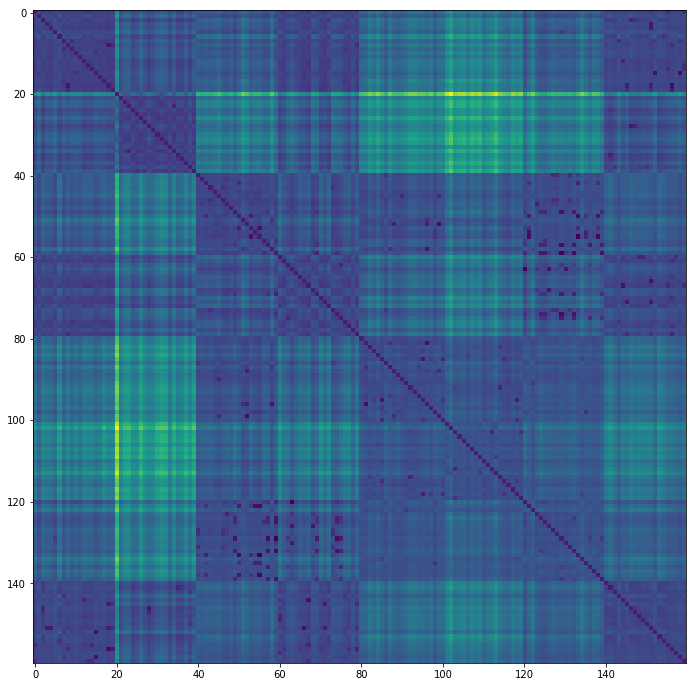

In [11]:
plt.figure(figsize=(12, 12))
plt.imshow(jsmat + jsmat.T)
plt.savefig(os.path.join(figsavepth, "JSDivAltogether_shuffle.pdf"))

In [ ]:
print(combined_poptens)